In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


object


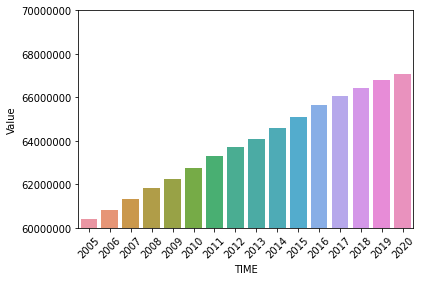

In [2]:
#import and clean dataset
countries_data = pd.read_csv("raw_data/HISTPOP_16102021224139462.csv")

uk_data = countries_data[countries_data["Country"] == "United Kingdom"]
print(uk_data.Age.dtypes)

uk_pop = uk_data[(uk_data.Age == "Total") & (uk_data.Sex == "Total")].groupby(by="Time").sum()

#print(uk_pop.columns)
sns.barplot(data=uk_pop, x="TIME", y="Value")
plt.ylim(60000000,70000000)
plt.xticks(rotation=45, ha="center")
plt.ticklabel_format(style='plain', axis='y')

plt.show()


In [15]:
#create country class 

class Country():
  pd.options.display.float_format = '{:,.2f}'.format
  def __init__(self, name):
    self.name = name
    self.country_data = countries_data[countries_data["Country"] == name]

  def pop_over_time(self):
    pop_data = self.country_data.groupby(by=["Time", "Sex", "Age"]).sum().reset_index(drop=False)
    pop_data = pop_data[pop_data.Age.str.contains(pat="^\w{1,2} to \w{1,4}$|85 and over|^Total$")]
    Age_labels = pop_data.Age.unique().tolist()
    Age_labels.insert(1, Age_labels.pop(11))
    Age_labels.remove("15 to 64")
    Age_labels.remove("20 to 64")
    pop_data = pop_data[pop_data.Age.str.contains("|".join(Age_labels))]
    pop_data.drop(columns=["TIME", "Flag Codes", "Flags"], inplace=True)
    pop_data.rename({"Time": "Year", "Value": "Population"}, axis=1, inplace=True)
    pop_data.sort_values(by=["Year", "Age", "Population"], inplace=True, ascending=True)
    pop_data.reset_index(drop=True, inplace=True)
    return pop_data
  
  def chart_pop_growth(self, by_sex=False):
    fig, ax, = plt.subplots(figsize=(16,10))
    data = self.pop_over_time()
    if by_sex == False:
      total_pop = data[(data.Sex == "Total") & (data.Age == "Total")]
      min_pop = min(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) - 1000000
      max_pop = max(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) + 1000000
      sns.barplot(data=total_pop, x="Year", y="Population", ax=ax)
      ax.ticklabel_format(style="plain", axis="y")
      ax.set_ylim(min_pop, max_pop)
      ax.set_title(f'{self.name} Population over time: 2005 - 2020')
    elif by_sex == True:
      sex_pop = data[data.Age == "Total"]
      sns.barplot(data=sex_pop, x="Year", y="Population", hue="Sex", ax=ax)
      ax.ticklabel_format(style="plain", axis="y")
      ax.set_title(f'{self.name} Population over time by sex: 2005 - 2020')
    

    plt.show()

  def chart_pop_by_age(self):
    data = self.pop_over_time()
    fig, axs = plt.subplots(3,5, figsize=(30,20))
    years = data.Year.unique()
    order = data.Age.unique().tolist()
    order.insert(1, order.pop(9))
    order.remove("Total")
    fig.suptitle(f"Population data for {self.name}", fontsize=16)

    for i, ax in enumerate(fig.axes):
      yr_data = data[(data["Year"] == years[i]) & (data["Sex"] == "Total") & (data["Age"] != "Total")]
      sns.barplot(data=yr_data, x="Age", y="Population", ax=ax, order=order)
      ax.set_title(f"Population for {years[i]} by age category")
      ax.set_xticklabels(labels=order, rotation=90)

    plt.tight_layout(pad=4)
    plt.show()
      
  

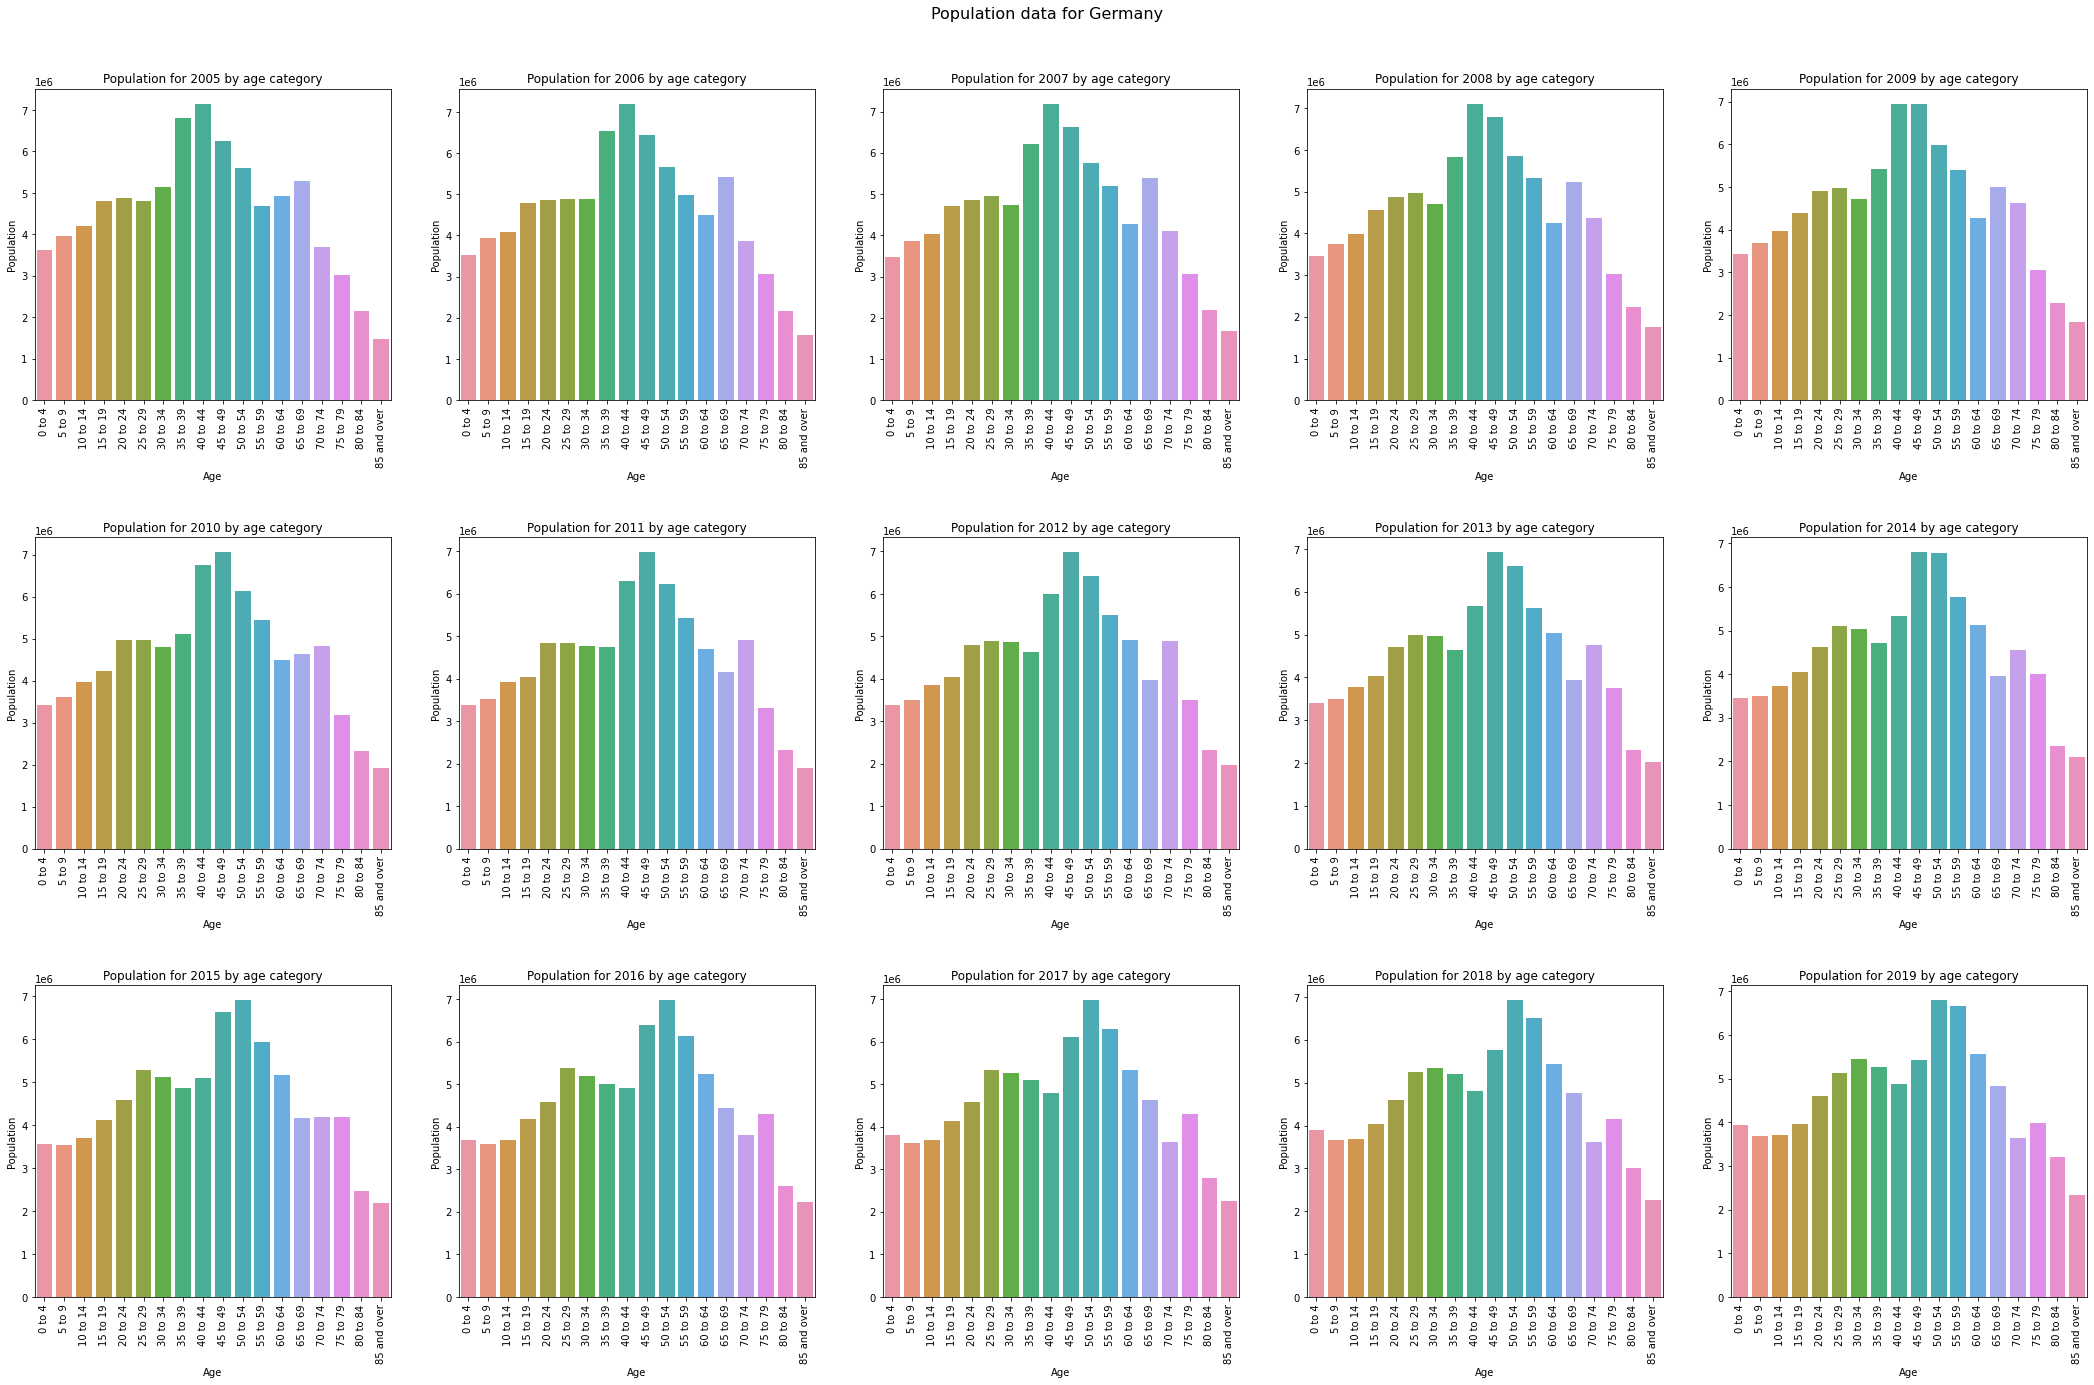

In [16]:
germany = Country("Germany")
uk = Country("United Kingdom")

germany.chart_pop_by_age()

#uk.chart_pop_growth(by_sex=True)